In [1]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[7] == eventname]
    
    if not timestamps:
        print(f"No {eventname} events found in file: {filename}")
        return []

    refpoint = datetime.strptime(rows[0][0].split()[0] + " 07:00:00", date_format)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return [0] * 15

    IPIs = np.diff(np.array(pellettimes))
    meals, snacks, mega_meals = [], [], []
    current_event = [pellettimes[0]]
    hourly_meals, hourly_snacks, hourly_mega_meals = [[0]*24 for _ in range(7)], [[0]*24 for _ in range(7)], [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            classify_event(current_event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals)
            current_event = [pellettimes[i + 1]]
    
    classify_event(current_event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals)

    total_obs_period = max(pellettimes) - min(pellettimes) if pellettimes else 1
    return compute_metrics(meals, snacks, mega_meals, total_obs_period, hourly_meals, hourly_snacks, hourly_mega_meals)

def classify_event(event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals):
    day_index, hour = int(event[0] // 24), int(event[0]) % 24
    if len(event) == 1:
        snacks.append(event)
        if day_index < 7: hourly_snacks[day_index][hour] += 1
    elif 2 <= len(event) <= 5:
        meals.append(event)
        if day_index < 7: hourly_meals[day_index][hour] += 1
    elif len(event) >= 6:
        mega_meals.append(event)
        if day_index < 7: hourly_mega_meals[day_index][hour] += 1

def compute_metrics(meals, snacks, mega_meals, period, hourly_meals, hourly_snacks, hourly_mega_meals):
    return [
        sum(len(m) for m in meals) / len(meals) if meals else 0,
        sum(len(s) for s in snacks) / len(snacks) if snacks else 0,
        len(meals), len(meals)/period if period else 0,
        len(snacks), len(snacks)/period if period else 0,
        len(mega_meals)/period if period else 0,
        sum(len(m) for m in mega_meals) / len(mega_meals) if mega_meals else 0,
        hourly_meals, hourly_snacks, hourly_mega_meals, meals, snacks, mega_meals, len(mega_meals)
    ]

def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}
    
    for row in rows:
        mouse_id = row[1]
        if mouse_id not in mice:
            mice[mouse_id] = {"sex": row[4], "order": row[5]}
        filename = f"../data/{row[0]}"
        epoch_key = f"epoch_{row[6]}"
        mice[mouse_id].setdefault(epoch_key, get_FEDevents(filename, "Pellet"))
    
    for key in mice.keys():
        for epoch in ["E1", "E2", "E3", "E4"]:
            epoch_key = f"epoch_{epoch}"
            metrics = get_meal_and_snack_metrics(mice[key].get(epoch_key, []))
            mice[key].update({f"{epoch_key}_{m}": v for m, v in zip(["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks", "snack_frequency", "mega_meal_frequency", "mega_meal_size", "hourly_meals", "hourly_snacks", "hourly_mega_meals", "meals", "snacks", "mega_meals", "number_of_mega_meals"], metrics)})
    
    return mice

# Load the new metafile and process it
metafile_path = "../FEDXC_METAFILE.csv"
mice_data = process_metafile(metafile_path)

# Output the results
for key, value in mice_data.items():
    print(f"Mouse {key}: Epoch-wise meal data")
    for epoch in ["E1", "E2", "E3", "E4"]:
        print(f"  {epoch}: {mice_data[key][f'epoch_{epoch}_number_of_meals']} meals, {mice_data[key][f'epoch_{epoch}_meal_frequency']} meals/hr")

Mouse FEDXC01: Epoch-wise meal data
  E1: 335 meals, 1.552441233148096 meals/hr
  E2: 290 meals, 1.7271642907128524 meals/hr
  E3: 243 meals, 1.4468879009209274 meals/hr
  E4: 291 meals, 1.7451710437542167 meals/hr
Mouse FEDXC02: Epoch-wise meal data
  E1: 364 meals, 1.6894457344202651 meals/hr
  E2: 307 meals, 1.8298225310558234 meals/hr
  E3: 328 meals, 1.9532723266570065 meals/hr
  E4: 322 meals, 1.9294177958498877 meals/hr
Mouse FEDXC03: Epoch-wise meal data
  E1: 313 meals, 1.4518261210164327 meals/hr
  E2: 229 meals, 1.3681647772251349 meals/hr
  E3: 276 meals, 1.6491395793499042 meals/hr
  E4: 272 meals, 1.632555068723366 meals/hr
Mouse FEDXC04: Epoch-wise meal data
  E1: 381 meals, 1.9900035546141068 meals/hr
  E2: 340 meals, 2.0237559852913947 meals/hr
  E3: 369 meals, 2.2021451187772496 meals/hr
  E4: 336 meals, 2.0125585249223827 meals/hr
Mouse FEDXC05: Epoch-wise meal data
  E1: 409 meals, 1.8972050885916434 meals/hr
  E2: 415 meals, 2.4668608452713547 meals/hr
  E3: 358 me

Mouse FEDXC01: Epoch-wise meal data
  E1: 335 meals, 1.552441233148096 meals/hr
  E2: 290 meals, 1.7271642907128524 meals/hr
  E3: 243 meals, 1.4468879009209274 meals/hr
  E4: 291 meals, 1.7451710437542167 meals/hr
Mouse FEDXC02: Epoch-wise meal data
  E1: 364 meals, 1.6894457344202651 meals/hr
  E2: 307 meals, 1.8298225310558234 meals/hr
  E3: 328 meals, 1.9532723266570065 meals/hr
  E4: 322 meals, 1.9294177958498877 meals/hr
Mouse FEDXC03: Epoch-wise meal data
  E1: 313 meals, 1.4518261210164327 meals/hr
  E2: 229 meals, 1.3681647772251349 meals/hr
  E3: 276 meals, 1.6491395793499042 meals/hr
  E4: 272 meals, 1.632555068723366 meals/hr
Mouse FEDXC04: Epoch-wise meal data
  E1: 381 meals, 1.9900035546141068 meals/hr
  E2: 340 meals, 2.0237559852913947 meals/hr
  E3: 369 meals, 2.2021451187772496 meals/hr
  E4: 336 meals, 2.0125585249223827 meals/hr
Mouse FEDXC05: Epoch-wise meal data
  E1: 409 meals, 1.8972050885916434 meals/hr
  E2: 415 meals, 2.4668608452713547 meals/hr
  E3: 358 me

In [3]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[7] == eventname]
    
    if not timestamps:
        print(f"No {eventname} events found in file: {filename}")
        return []

    refpoint = datetime.strptime(rows[0][0].split()[0] + " 07:00:00", date_format)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_events_per_day(events, days):
    events_per_day = [0] * days
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

def get_pellets_per_day(timestamps, days):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        pellets_per_day[day] = len(pellets)
    return pellets_per_day

def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}
    
    for row in rows:
        mouse_id = row[1]
        if mouse_id not in mice:
            mice[mouse_id] = {"sex": row[4], "order": row[5]}
        filename = f"../data/{row[0]}"
        epoch_key = f"epoch_{row[6]}"
        mice[mouse_id].setdefault(epoch_key, get_FEDevents(filename, "Pellet"))
    
    for key in mice.keys():
        for epoch, days in zip(["E1", "E2", "E3", "E4"], [9, 7, 7, 7]):
            epoch_key = f"epoch_{epoch}"
            metrics = get_meal_and_snack_metrics(mice[key].get(epoch_key, []))
            mice[key].update({f"{epoch_key}_{m}": v for m, v in zip(["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks", "snack_frequency", "mega_meal_frequency", "mega_meal_size", "hourly_meals", "hourly_snacks", "hourly_mega_meals", "meals", "snacks", "mega_meals", "number_of_mega_meals"], metrics)})
            mice[key][f"{epoch_key}_pellets_per_day"] = get_pellets_per_day(mice[key].get(epoch_key, []), days)
            mice[key][f"{epoch_key}_meals_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_meals"], days)
            mice[key][f"{epoch_key}_snacks_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_snacks"], days)
            mice[key][f"{epoch_key}_mega_meals_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_mega_meals"], days)
    
    return mice

# Load the new metafile and process it
metafile_path = "../FEDXC_METAFILE.csv"
mice_data = process_metafile(metafile_path)

# Save results to CSV
output_file = "epoch_analysis_results.csv"
with open(output_file, "w", newline="") as csvfile:
    fieldnames = ["mouse_id", "sex", "order"] + [f"epoch_{epoch}_{metric}" for epoch in ["E1", "E2", "E3", "E4"] for metric in ["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks", "snack_frequency", "mega_meal_frequency", "mega_meal_size", "pellets_per_day", "meals_per_day", "snacks_per_day", "mega_meals_per_day"]]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for key, value in mice_data.items():
        row = {"mouse_id": key, "sex": value["sex"], "order": value["order"]}
        for epoch in ["E1", "E2", "E3", "E4"]:
            for metric in ["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks", "snack_frequency", "mega_meal_frequency", "mega_meal_size", "pellets_per_day", "meals_per_day", "snacks_per_day", "mega_meals_per_day"]:
                row[f"epoch_{epoch}_{metric}"] = value.get(f"epoch_{epoch}_{metric}", 0)
        writer.writerow(row)

print(f"Results saved to {output_file}")

Results saved to epoch_analysis_results.csv


In [75]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[7] == eventname]
    
    if not timestamps:
        print(f"No {eventname} events found in file: {filename}")
        return []

    refpoint = datetime.strptime(rows[0][0].split()[0] + " 07:00:00", date_format)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return [0] * 15

    IPIs = np.diff(np.array(pellettimes))
    meals, snacks, mega_meals = [], [], []
    current_event = [pellettimes[0]]
    hourly_meals = [[0]*24 for _ in range(7)]
    hourly_snacks = [[0]*24 for _ in range(7)]
    hourly_mega_meals = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            classify_event(current_event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals)
            current_event = [pellettimes[i + 1]]
    
    classify_event(current_event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals)

    total_obs_period = max(pellettimes) - min(pellettimes) if pellettimes else 1
    return compute_metrics(meals, snacks, mega_meals, total_obs_period, hourly_meals, hourly_snacks, hourly_mega_meals)

def classify_event(event, meals, snacks, mega_meals, hourly_meals, hourly_snacks, hourly_mega_meals):
    day_index, hour = int(event[0] // 24), int(event[0]) % 24
    if len(event) == 1:
        snacks.append(event)
        if day_index < 7:
            hourly_snacks[day_index][hour] += 1
    elif 2 <= len(event) <= 5:
        meals.append(event)
        if day_index < 7:
            hourly_meals[day_index][hour] += 1
    elif len(event) >= 6:
        mega_meals.append(event)
        if day_index < 7:
            hourly_mega_meals[day_index][hour] += 1

def compute_metrics(meals, snacks, mega_meals, period, hourly_meals, hourly_snacks, hourly_mega_meals):
    return [
        sum(len(m) for m in meals) / len(meals) if meals else 0,     # meal_size
        sum(len(s) for s in snacks) / len(snacks) if snacks else 0,     # snack_size
        len(meals),                                                   # number_of_meals
        len(meals) / period if period else 0,                           # meal_frequency
        len(snacks),                                                  # number_of_snacks
        len(snacks) / period if period else 0,                          # snack_frequency
        len(mega_meals) / period if period else 0,                      # mega_meal_frequency
        sum(len(m) for m in mega_meals) / len(mega_meals) if mega_meals else 0,  # mega_meal_size
        hourly_meals,   # hourly_meals (list)
        hourly_snacks,  # hourly_snacks (list)
        hourly_mega_meals,  # hourly_mega_meals (list)
        meals,          # raw meals data
        snacks,         # raw snacks data
        mega_meals,     # raw mega meals data
        len(mega_meals) # number_of_mega_meals
    ]

def get_events_per_day(events, days):
    events_per_day = [0] * days
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

def get_pellets_per_day(timestamps, days):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        pellets_per_day[day] = len(pellets)
    return pellets_per_day

def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}
    
    for row in rows:
        mouse_id = row[1]
        if mouse_id not in mice:
            mice[mouse_id] = {"sex": row[4], "order": row[5]}
        filename = f"../data/{row[0]}"
        epoch_key = f"epoch_{row[6]}"
        mice[mouse_id].setdefault(epoch_key, get_FEDevents(filename, "Pellet"))
    
    for key in mice.keys():
        for epoch, days in zip(["E1", "E2", "E3", "E4"], [9, 7, 7, 7]):
            epoch_key = f"epoch_{epoch}"
            metrics = get_meal_and_snack_metrics(mice[key].get(epoch_key, []))
            mice[key].update({f"{epoch_key}_{m}": v for m, v in zip(
                ["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks", "snack_frequency",
                 "mega_meal_frequency", "mega_meal_size", "hourly_meals", "hourly_snacks", "hourly_mega_meals",
                 "meals", "snacks", "mega_meals", "number_of_mega_meals"], metrics)})
            mice[key][f"{epoch_key}_pellets_per_day"] = get_pellets_per_day(mice[key].get(epoch_key, []), days)
            mice[key][f"{epoch_key}_meals_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_meals"], days)
            mice[key][f"{epoch_key}_snacks_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_snacks"], days)
            mice[key][f"{epoch_key}_mega_meals_per_day"] = get_events_per_day(mice[key][f"{epoch_key}_mega_meals"], days)
    
    return mice

# Load the metafile and process it
metafile_path = "../FEDXC_METAFILE.csv"
mice_data = process_metafile(metafile_path)

# Save results to CSV, now including "number_of_mega_meals"
output_file = "epoch_analysis_results_2.csv"
with open(output_file, "w", newline="") as csvfile:
    # Updated fieldnames: "number_of_mega_meals" is now included
    fieldnames = ["mouse_id", "sex", "order"] + [
        f"epoch_{epoch}_{metric}" for epoch in ["E1", "E2", "E3", "E4"] 
        for metric in ["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks",
                       "snack_frequency", "mega_meal_frequency", "mega_meal_size", "number_of_mega_meals",
                       "pellets_per_day", "meals_per_day", "snacks_per_day", "mega_meals_per_day"]
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for key, value in mice_data.items():
        row = {"mouse_id": key, "sex": value["sex"], "order": value["order"]}
        for epoch in ["E1", "E2", "E3", "E4"]:
            for metric in ["meal_size", "snack_size", "number_of_meals", "meal_frequency", "number_of_snacks",
                           "snack_frequency", "mega_meal_frequency", "mega_meal_size", "number_of_mega_meals",
                           "pellets_per_day", "meals_per_day", "snacks_per_day", "mega_meals_per_day"]:
                row[f"epoch_{epoch}_{metric}"] = value.get(f"epoch_{epoch}_{metric}", 0)
        writer.writerow(row)

print(f"Results saved to {output_file}")


Results saved to epoch_analysis_results_2.csv


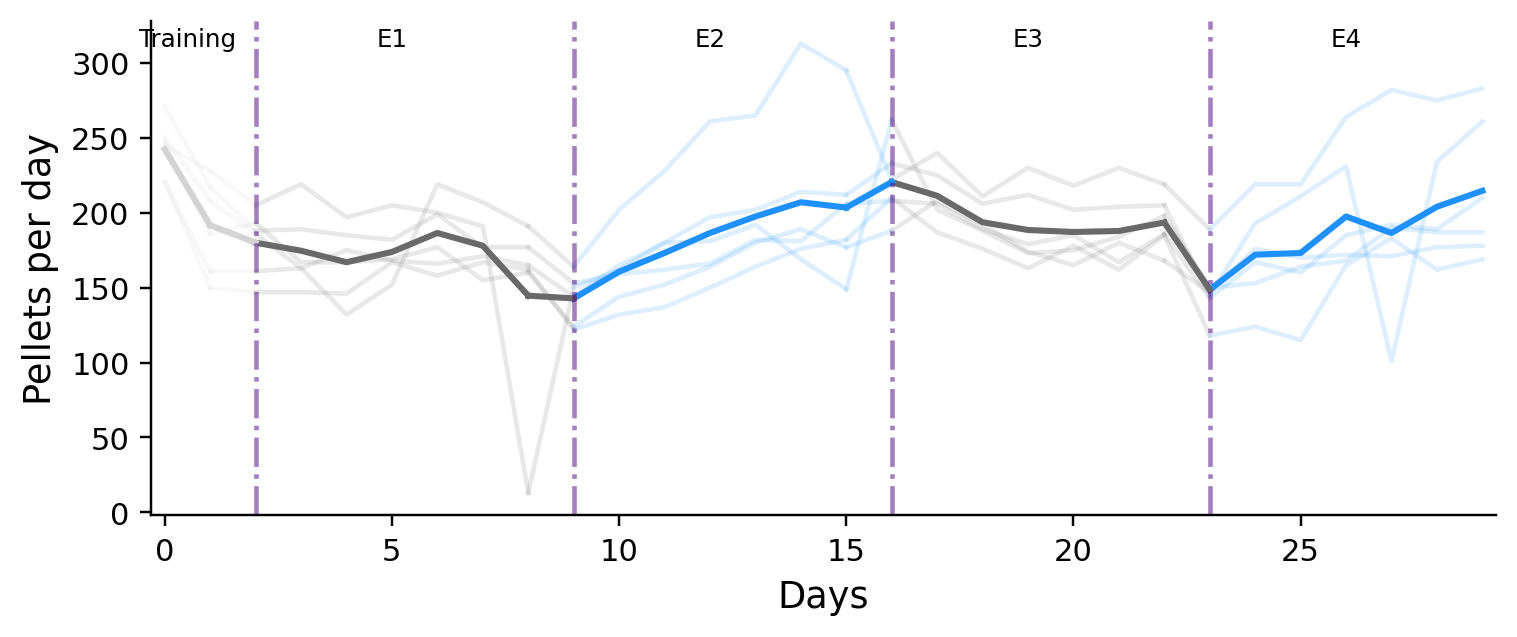

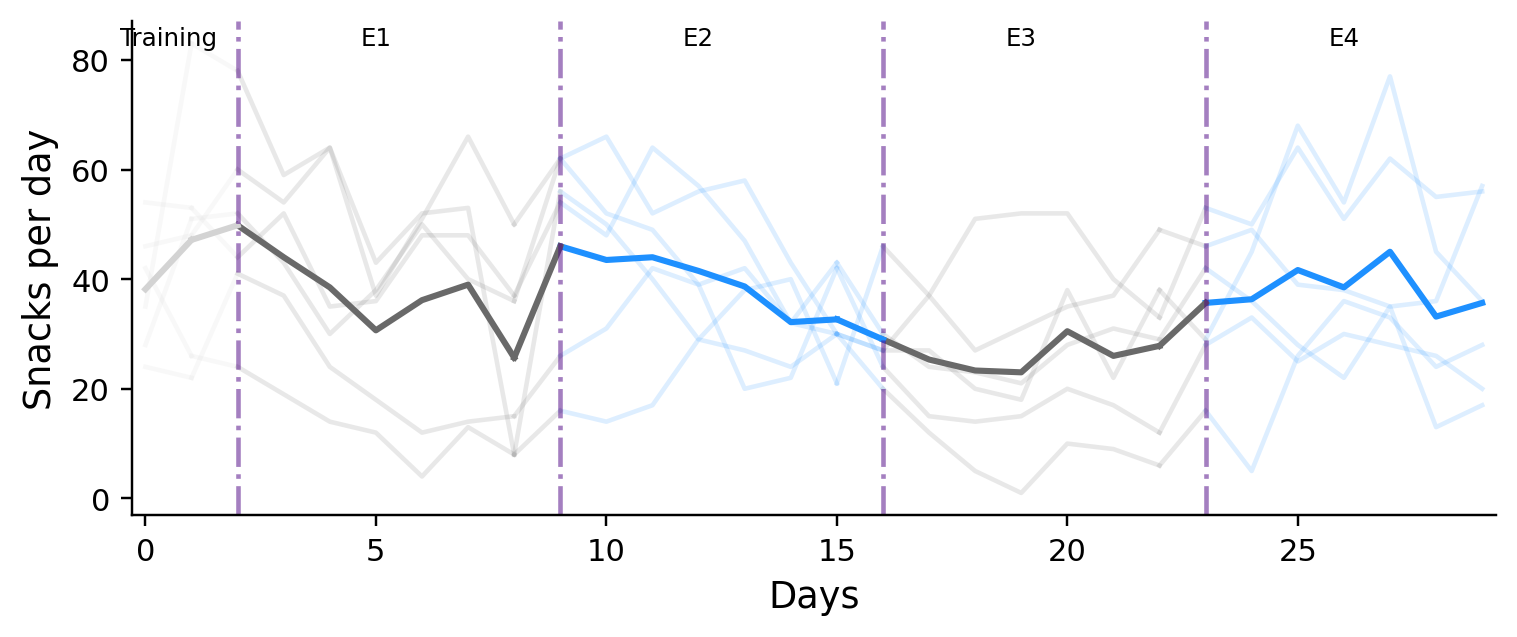

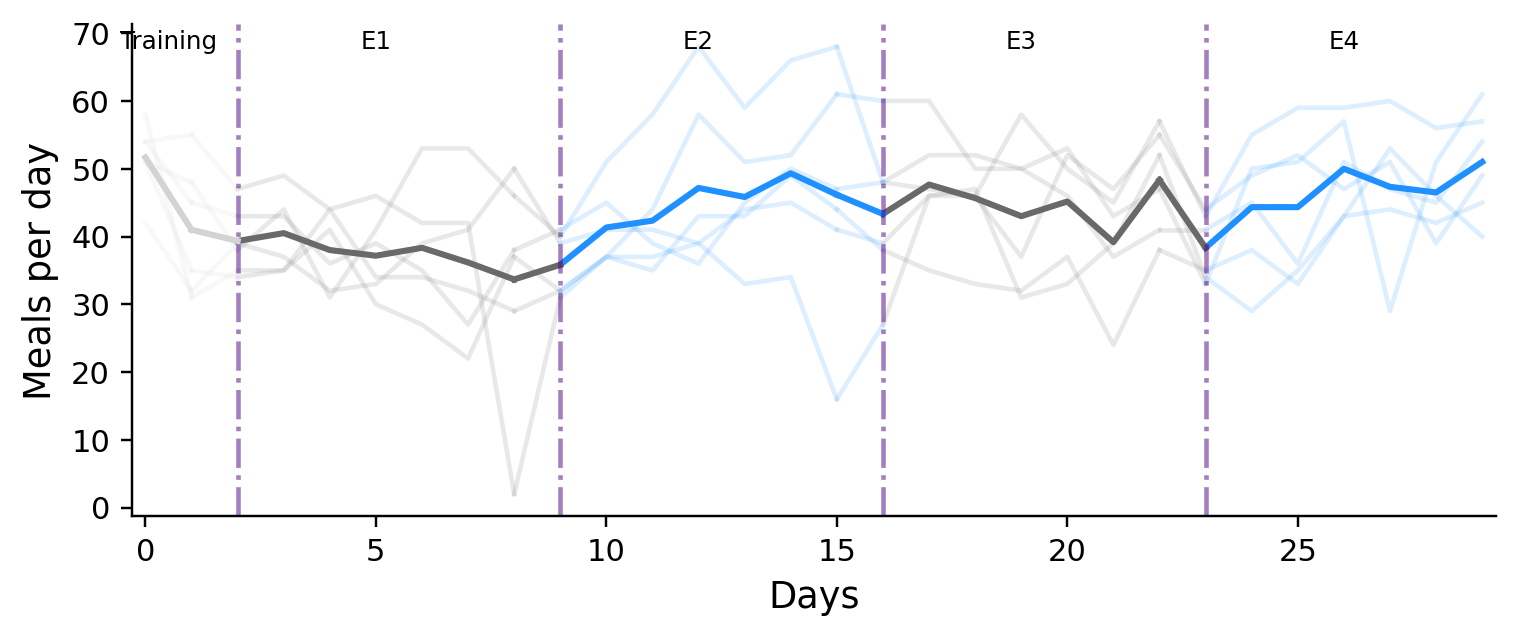

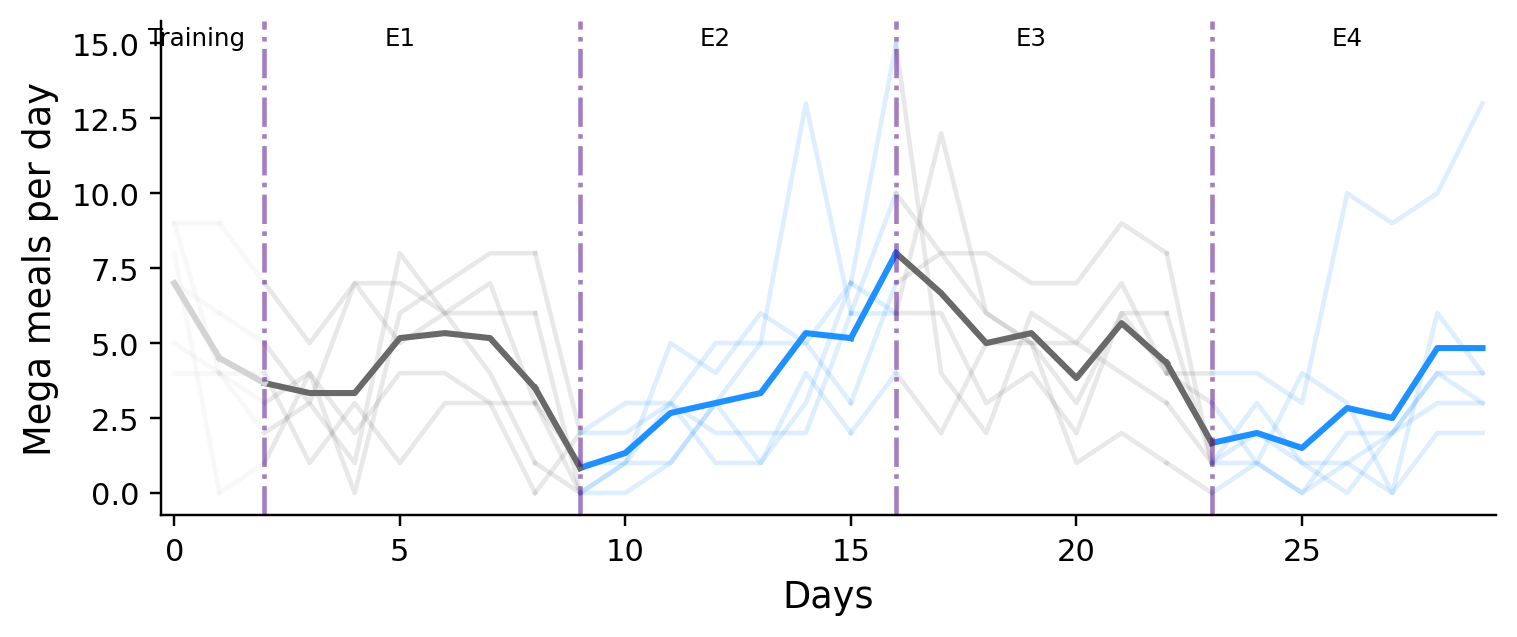

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# -----------------------------
# 1. Load CSV and Filter for Order 2
# -----------------------------
csv_path = "epoch_analysis_results_2.csv"
df = pd.read_csv(csv_path)
df_order2 = df[df["order"] == 2].copy()

# -----------------------------
# 2. Convert Per-Day Columns to Lists
# -----------------------------
def convert_to_list(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

metrics = ["pellets_per_day", "snacks_per_day", "meals_per_day", "mega_meals_per_day"]
epochs = ["E1", "E2", "E3", "E4"]

for epoch in epochs:
    for metric in metrics:
        col = f"epoch_{epoch}_{metric}"
        if col in df_order2.columns:
            df_order2[col] = df_order2[col].apply(convert_to_list)

# -----------------------------
# 3. Build Continuous Timeline for Each Metric
# -----------------------------
# E1 = 9 days (0–8); first 2 days (0–1) = training
# E2, E3, E4 = 7 days each => total 30 days (0–29)
def build_trace(row, metric):
    trace = []
    for epoch in epochs:
        col = f"epoch_{epoch}_{metric}"
        daily_vals = row.get(col, [])
        trace += daily_vals
    # Ensure we have exactly 30 days
    if len(trace) < 30:
        trace += [0]*(30-len(trace))
    return trace[:30]

order2_traces = {metric: [] for metric in metrics}

for _, row in df_order2.iterrows():
    for metric in metrics:
        day_by_day = build_trace(row, metric)
        order2_traces[metric].append(day_by_day)

for metric in metrics:
    order2_traces[metric] = np.array(order2_traces[metric])  # shape: (n_mice, 30)

# -----------------------------
# 4. Plotting Setup & Timeline (Order 2 Only)
# -----------------------------
# Segments:
#   Training = days 0–1 -> (0,2)
#   E1 = days 2–8       -> (2,9)
#   E2 = days 9–15      -> (9,16)
#   E3 = days 16–22     -> (16,23)
#   E4 = days 23–29     -> (23,30)
segments = [(0, 2), (2, 9), (9, 16), (16, 23), (23, 30)]
segment_labels = ["Training", "E1", "E2", "E3", "E4"]

# Keep your original color pattern
segment_colors = ["lightgray", "dimgray", "dodgerblue", "dimgray", "dodgerblue"]

total_days = 30
ylabels = {
    "pellets_per_day": "Pellets per day",
    "snacks_per_day":  "Snacks per day",
    "meals_per_day":   "Meals per day",
    "mega_meals_per_day": "Mega meals per day"
}

for metric in metrics:
    data = order2_traces[metric]  # shape: (n_mice, 30)
    n_mice = data.shape[0]
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=220)
    
    # Plot each mouse's trace, segment-by-segment
    for i in range(n_mice):
        trace = data[i, :]
        for seg_idx, (start, end) in enumerate(segments):
            x_seg = np.arange(start, end)
            y_seg = trace[start:end]
            # Each segment in the color for that segment
            ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
        # Connect boundaries with the color of the CURRENT segment
        for seg_idx in range(len(segments) - 1):
            boundary = segments[seg_idx][1]  # e.g. 2 -> 9 -> 16 -> 23
            if boundary - 1 < len(trace) and boundary < len(trace):
                x_connect = [boundary - 1, boundary]
                y_connect = [trace[boundary - 1], trace[boundary]]
                # Use the color of the current segment (seg_idx),
                # not seg_idx+1
                ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
    
    # Overplot the mean trace in thicker lines
    mean_trace = np.nanmean(data, axis=0)
    for seg_idx, (start, end) in enumerate(segments):
        x_seg = np.arange(start, end)
        y_seg = mean_trace[start:end]
        ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linewidth=2)
    # Connect boundaries of the mean trace w/ the current segment color
    for seg_idx in range(len(segments) - 1):
        boundary = segments[seg_idx][1]
        if boundary - 1 < len(mean_trace) and boundary < len(mean_trace):
            x_connect = [boundary - 1, boundary]
            y_connect = [mean_trace[boundary - 1], mean_trace[boundary]]
            ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linewidth=2)
    
    # Vertical dashed lines at segment boundaries
    for boundary in [2, 9, 16, 23]:
        ax.axvline(boundary, linestyle='-.', color='indigo', alpha=0.5)
    
    # Segment labels (midpoints) near top
    y_top = ax.get_ylim()[1]
    for seg_idx, (start, end) in enumerate(segments):
        mid = (start + end - 1) / 2
        ax.text(mid, 0.95 * y_top, segment_labels[seg_idx], ha='center', fontsize=8)
    
    # X / Y labels and ticks
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel(ylabels[metric], fontsize=12)
    ax.set_xticks(range(0, total_days+1, 5))
    
    # Tiny gap on left/right
    ax.set_xlim(-0.3, 29.3)
    
    # Style: remove top/right spines, no grid
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    # Save if desired
    # fig.savefig(f"line_plot_{metric}_order2.png", bbox_inches='tight', dpi=220)


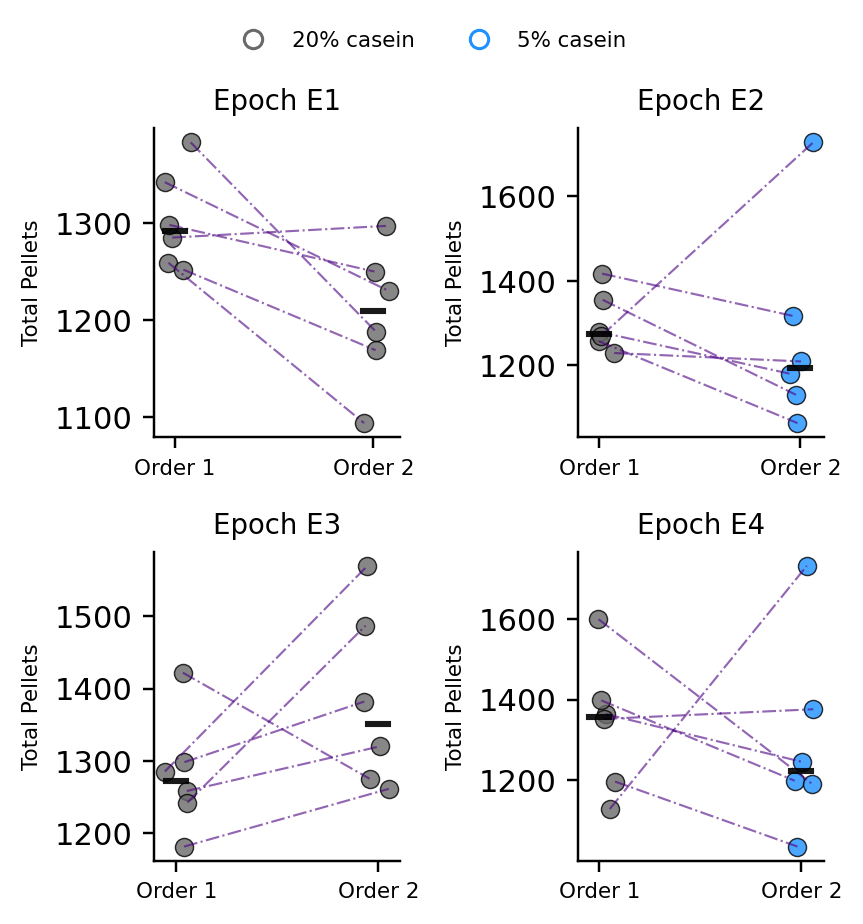

In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to pellet count columns
for epoch in ["E1", "E2", "E3", "E4"]:
    epoch_results_df[f"epoch_{epoch}_pellets_per_day"] = epoch_results_df[f"epoch_{epoch}_pellets_per_day"].apply(convert_to_list)

# Compute total pellets per epoch per order
total_pellets_per_epoch = {"E1": {"Order 1": [], "Order 2": []},
                           "E2": {"Order 1": [], "Order 2": []},
                           "E3": {"Order 1": [], "Order 2": []},
                           "E4": {"Order 1": [], "Order 2": []}}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        pellet_data = row[f"epoch_{epoch}_pellets_per_day"]
        if epoch == "E1":  # Exclude first two days of training
            pellet_data = pellet_data[2:]
        total_pellets = sum(pellet_data)
        total_pellets_per_epoch[epoch][order].append(total_pellets)

# Plot total pellets per epoch for each order
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=220)
epochs = ["E1", "E2", "E3", "E4"]
jitter_strength = 0.08

for i, epoch in enumerate(epochs):
    ax = axes[i // 2, i % 2]
    orders = ["Order 1", "Order 2"]
    order1_data = total_pellets_per_epoch[epoch]["Order 1"]
    order2_data = total_pellets_per_epoch[epoch]["Order 2"]

    # Correct colors based on casein content
    colors = {"E1": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E2": {"Order 1": "dimgray", "Order 2": "dodgerblue"},
              "E3": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E4": {"Order 1": "dimgray", "Order 2": "dodgerblue"}}
    
    # Jittered x positions
    order1_x = [0 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order1_data]
    order2_x = [1 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order2_data]

    # Scatter plot with adjusted marker sizes
    sns.scatterplot(x=order1_x, y=order1_data, color=colors[epoch]["Order 1"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    sns.scatterplot(x=order2_x, y=order2_data, color=colors[epoch]["Order 2"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    
    for j in range(len(order1_data)):
        if j < len(order2_data):
            ax.plot([order1_x[j], order2_x[j]], [order1_data[j], order2_data[j]], color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
    
    # Add median lines for each order
    for order, data, x_pos in zip(["Order 1", "Order 2"], [order1_data, order2_data], [0, 1]):
        median_value = np.median(data)
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_value, median_value], color='black', linewidth=2, alpha=0.9)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Order 1", "Order 2"], fontsize=7)
    ax.set_ylabel("Total Pellets", fontsize=7)
    ax.set_title(f"Epoch {epoch}", fontsize=9)
    sns.despine()

# Customize legend with markers
custom_lines = [
    Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6, label='20% casein', fillstyle='none'),
    Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6, label='5% casein', fillstyle='none')
]
fig.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

#fig.savefig("..//plots/NEW_MEAL_PLOTS/total_pellets_per_epoch.png")

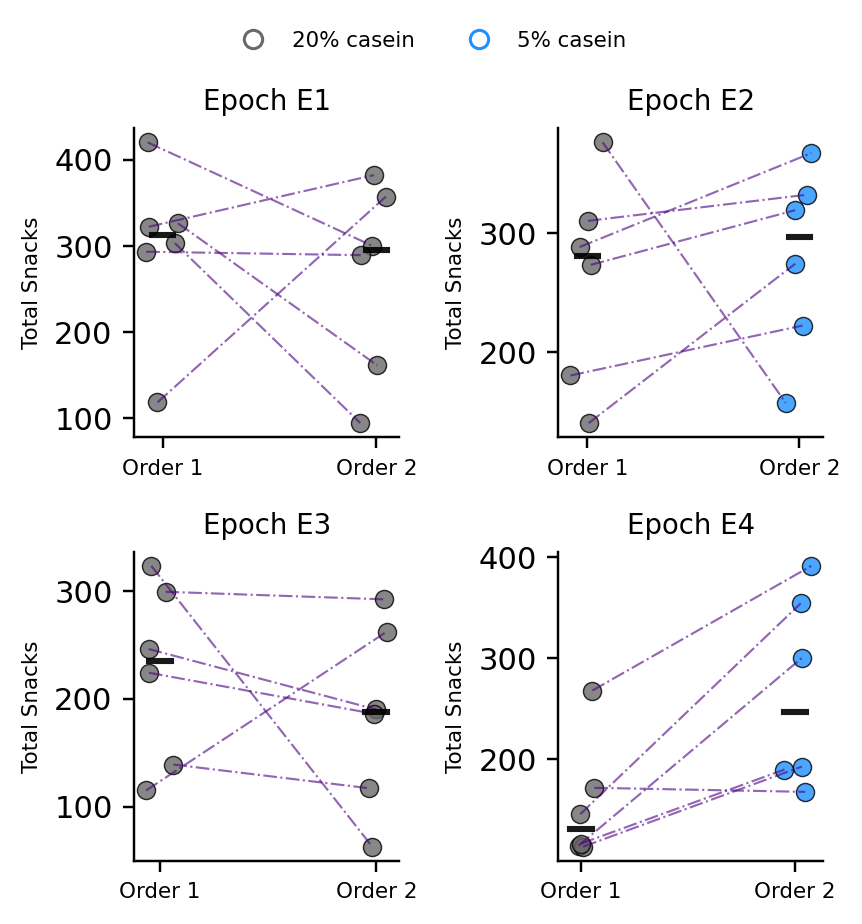

In [13]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to snack count columns
for epoch in ["E1", "E2", "E3", "E4"]:
    epoch_results_df[f"epoch_{epoch}_snacks_per_day"] = epoch_results_df[f"epoch_{epoch}_snacks_per_day"].apply(convert_to_list)

# Compute total snacks per epoch per order
total_snacks_per_epoch = {"E1": {"Order 1": [], "Order 2": []},
                           "E2": {"Order 1": [], "Order 2": []},
                           "E3": {"Order 1": [], "Order 2": []},
                           "E4": {"Order 1": [], "Order 2": []}}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        snack_data = row[f"epoch_{epoch}_snacks_per_day"]
        if epoch == "E1":  # Exclude first two days of training
            snack_data = snack_data[2:]
        total_snacks = sum(snack_data)
        total_snacks_per_epoch[epoch][order].append(total_snacks)

# Plot total snacks per epoch for each order
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=220)
epochs = ["E1", "E2", "E3", "E4"]
jitter_strength = 0.08

for i, epoch in enumerate(epochs):
    ax = axes[i // 2, i % 2]
    orders = ["Order 1", "Order 2"]
    order1_data = total_snacks_per_epoch[epoch]["Order 1"]
    order2_data = total_snacks_per_epoch[epoch]["Order 2"]

    # Correct colors based on casein content
    colors = {"E1": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E2": {"Order 1": "dimgray", "Order 2": "dodgerblue"},
              "E3": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E4": {"Order 1": "dimgray", "Order 2": "dodgerblue"}}
    
    # Jittered x positions
    order1_x = [0 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order1_data]
    order2_x = [1 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order2_data]

    # Scatter plot with adjusted marker sizes
    sns.scatterplot(x=order1_x, y=order1_data, color=colors[epoch]["Order 1"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    sns.scatterplot(x=order2_x, y=order2_data, color=colors[epoch]["Order 2"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    
    for j in range(len(order1_data)):
        if j < len(order2_data):
            ax.plot([order1_x[j], order2_x[j]], [order1_data[j], order2_data[j]], color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
    
    # Add median lines for each order
    for order, data, x_pos in zip(["Order 1", "Order 2"], [order1_data, order2_data], [0, 1]):
        median_value = np.median(data)
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_value, median_value], color='black', linewidth=2, alpha=0.9)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Order 1", "Order 2"], fontsize=7)
    ax.set_ylabel("Total Snacks", fontsize=7)
    ax.set_title(f"Epoch {epoch}", fontsize=9)
    sns.despine()

# Customize legend with markers
custom_lines = [
    Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6, label='20% casein', fillstyle='none'),
    Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6, label='5% casein', fillstyle='none')
]
fig.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

#fig.savefig("..//plots/NEW_MEAL_PLOTS/total_snacks_per_epoch.png")


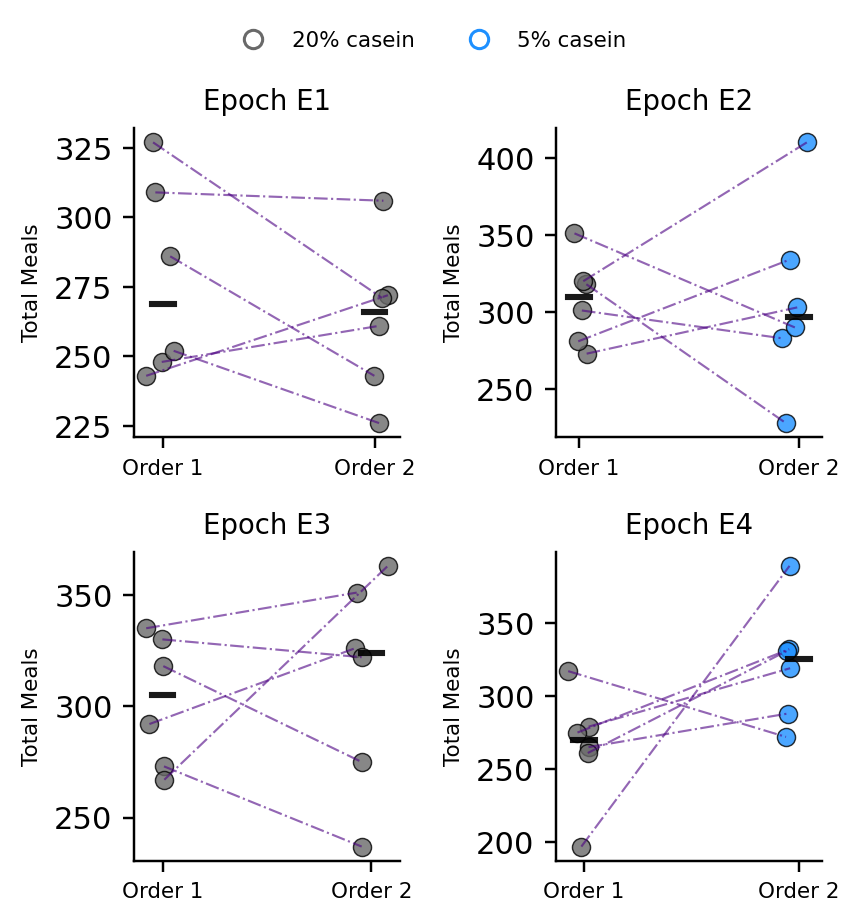

In [14]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to snack count columns
for epoch in ["E1", "E2", "E3", "E4"]:
    epoch_results_df[f"epoch_{epoch}_meals_per_day"] = epoch_results_df[f"epoch_{epoch}_meals_per_day"].apply(convert_to_list)

# Compute total snacks per epoch per order
total_meals_per_epoch = {"E1": {"Order 1": [], "Order 2": []},
                           "E2": {"Order 1": [], "Order 2": []},
                           "E3": {"Order 1": [], "Order 2": []},
                           "E4": {"Order 1": [], "Order 2": []}}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        snack_data = row[f"epoch_{epoch}_meals_per_day"]
        if epoch == "E1":  # Exclude first two days of training
            snack_data = snack_data[2:]
        total_meals = sum(snack_data)
        total_meals_per_epoch[epoch][order].append(total_meals)

# Plot total snacks per epoch for each order
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=220)
epochs = ["E1", "E2", "E3", "E4"]
jitter_strength = 0.08

for i, epoch in enumerate(epochs):
    ax = axes[i // 2, i % 2]
    orders = ["Order 1", "Order 2"]
    order1_data = total_meals_per_epoch[epoch]["Order 1"]
    order2_data = total_meals_per_epoch[epoch]["Order 2"]

    # Correct colors based on casein content
    colors = {"E1": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E2": {"Order 1": "dimgray", "Order 2": "dodgerblue"},
              "E3": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E4": {"Order 1": "dimgray", "Order 2": "dodgerblue"}}
    
    # Jittered x positions
    order1_x = [0 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order1_data]
    order2_x = [1 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order2_data]

    # Scatter plot with adjusted marker sizes
    sns.scatterplot(x=order1_x, y=order1_data, color=colors[epoch]["Order 1"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    sns.scatterplot(x=order2_x, y=order2_data, color=colors[epoch]["Order 2"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    
    for j in range(len(order1_data)):
        if j < len(order2_data):
            ax.plot([order1_x[j], order2_x[j]], [order1_data[j], order2_data[j]], color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
    
    # Add median lines for each order
    for order, data, x_pos in zip(["Order 1", "Order 2"], [order1_data, order2_data], [0, 1]):
        median_value = np.median(data)
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_value, median_value], color='black', linewidth=2, alpha=0.9)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Order 1", "Order 2"], fontsize=7)
    ax.set_ylabel("Total Meals", fontsize=7)
    ax.set_title(f"Epoch {epoch}", fontsize=9)
    sns.despine()

# Customize legend with markers
custom_lines = [
    Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6, label='20% casein', fillstyle='none'),
    Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6, label='5% casein', fillstyle='none')
]
fig.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

#fig.savefig("..//plots/NEW_MEAL_PLOTS/total_snacks_per_epoch.png")


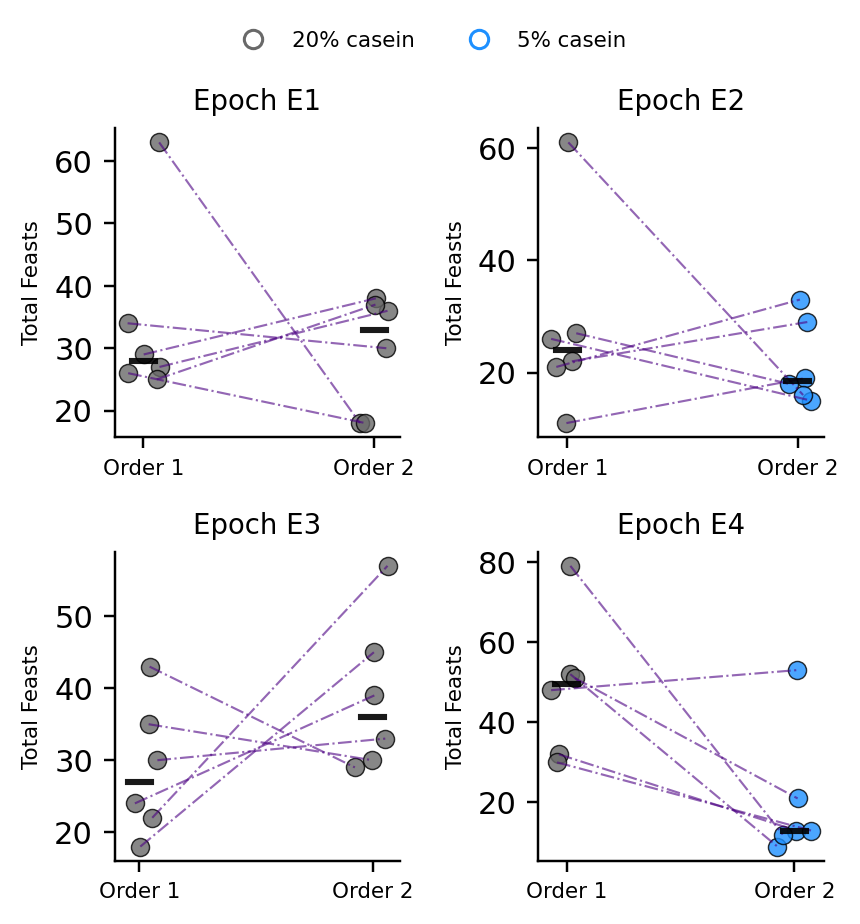

In [30]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to snack count columns
for epoch in ["E1", "E2", "E3", "E4"]:
    epoch_results_df[f"epoch_{epoch}_mega_meals_per_day"] = epoch_results_df[f"epoch_{epoch}_mega_meals_per_day"].apply(convert_to_list)

# Compute total snacks per epoch per order
total_mega_meals_per_epoch = {"E1": {"Order 1": [], "Order 2": []},
                           "E2": {"Order 1": [], "Order 2": []},
                           "E3": {"Order 1": [], "Order 2": []},
                           "E4": {"Order 1": [], "Order 2": []}}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        snack_data = row[f"epoch_{epoch}_mega_meals_per_day"]
        if epoch == "E1":  # Exclude first two days of training
            snack_data = snack_data[2:]
        total_mega_meals = sum(snack_data)
        total_mega_meals_per_epoch[epoch][order].append(total_mega_meals)

# Plot total snacks per epoch for each order
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=220)
epochs = ["E1", "E2", "E3", "E4"]
jitter_strength = 0.08

for i, epoch in enumerate(epochs):
    ax = axes[i // 2, i % 2]
    orders = ["Order 1", "Order 2"]
    order1_data = total_mega_meals_per_epoch[epoch]["Order 1"]
    order2_data = total_mega_meals_per_epoch[epoch]["Order 2"]

    # Correct colors based on casein content
    colors = {"E1": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E2": {"Order 1": "dimgray", "Order 2": "dodgerblue"},
              "E3": {"Order 1": "dimgray", "Order 2": "dimgray"},
              "E4": {"Order 1": "dimgray", "Order 2": "dodgerblue"}}
    
    # Jittered x positions
    order1_x = [0 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order1_data]
    order2_x = [1 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order2_data]

    # Scatter plot with adjusted marker sizes
    sns.scatterplot(x=order1_x, y=order1_data, color=colors[epoch]["Order 1"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    sns.scatterplot(x=order2_x, y=order2_data, color=colors[epoch]["Order 2"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
    
    for j in range(len(order1_data)):
        if j < len(order2_data):
            ax.plot([order1_x[j], order2_x[j]], [order1_data[j], order2_data[j]], color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
    
    # Add median lines for each order
    for order, data, x_pos in zip(["Order 1", "Order 2"], [order1_data, order2_data], [0, 1]):
        median_value = np.median(data)
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_value, median_value], color='black', linewidth=2, alpha=0.9)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Order 1", "Order 2"], fontsize=7)
    ax.set_ylabel("Total Feasts", fontsize=7)
    ax.set_title(f"Epoch {epoch}", fontsize=9)
    sns.despine()

# Customize legend with markers
custom_lines = [
    Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6, label='20% casein', fillstyle='none'),
    Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6, label='5% casein', fillstyle='none')
]
fig.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

#fig.savefig("..//plots/NEW_MEAL_PLOTS/total_snacks_per_epoch.png")


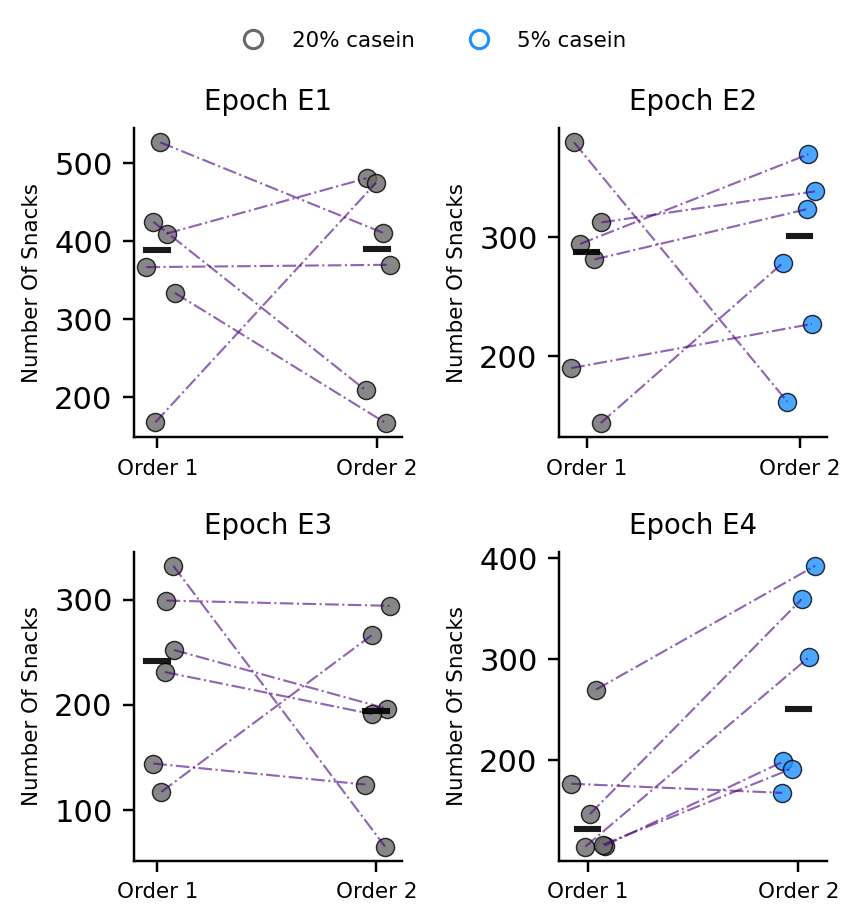

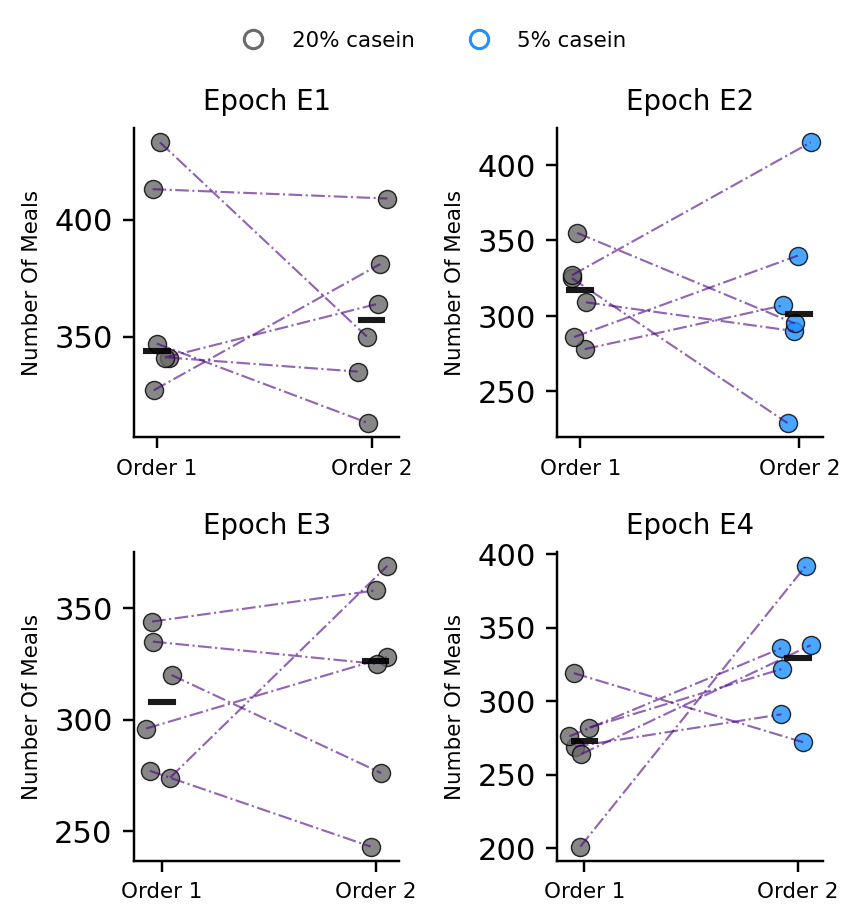

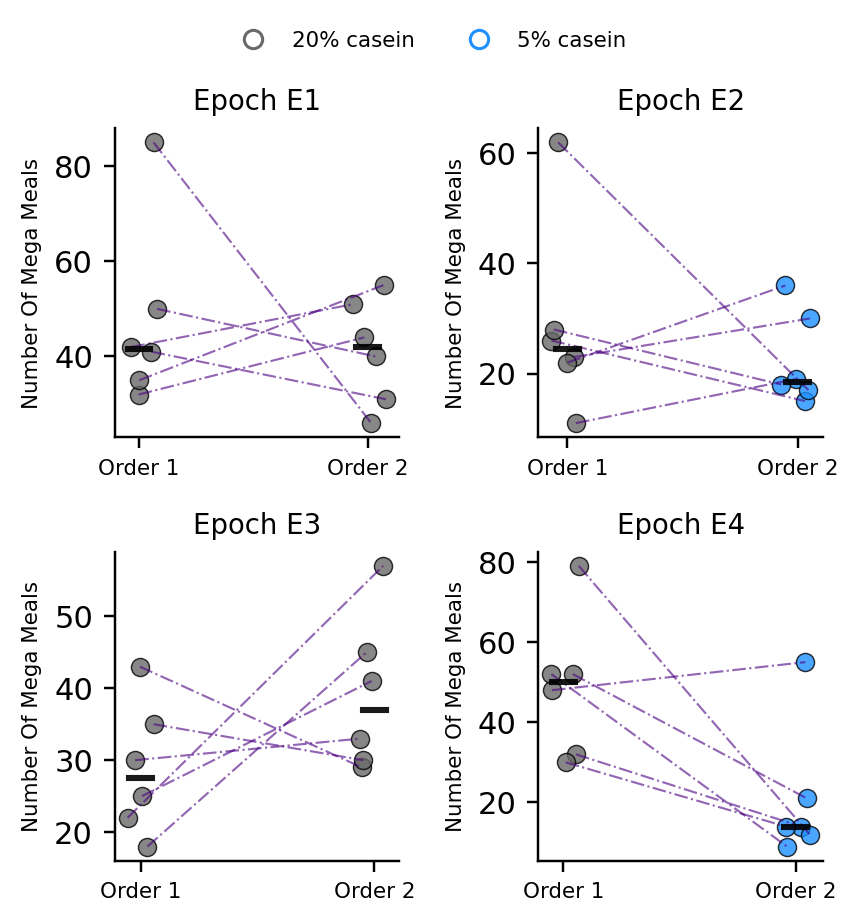

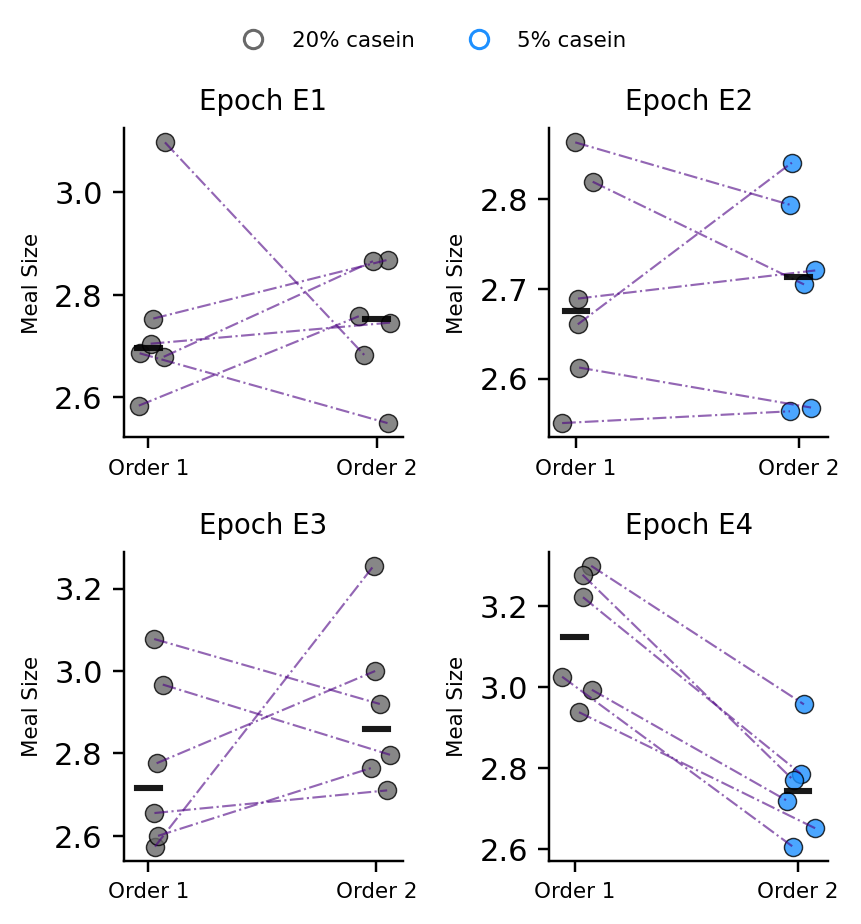

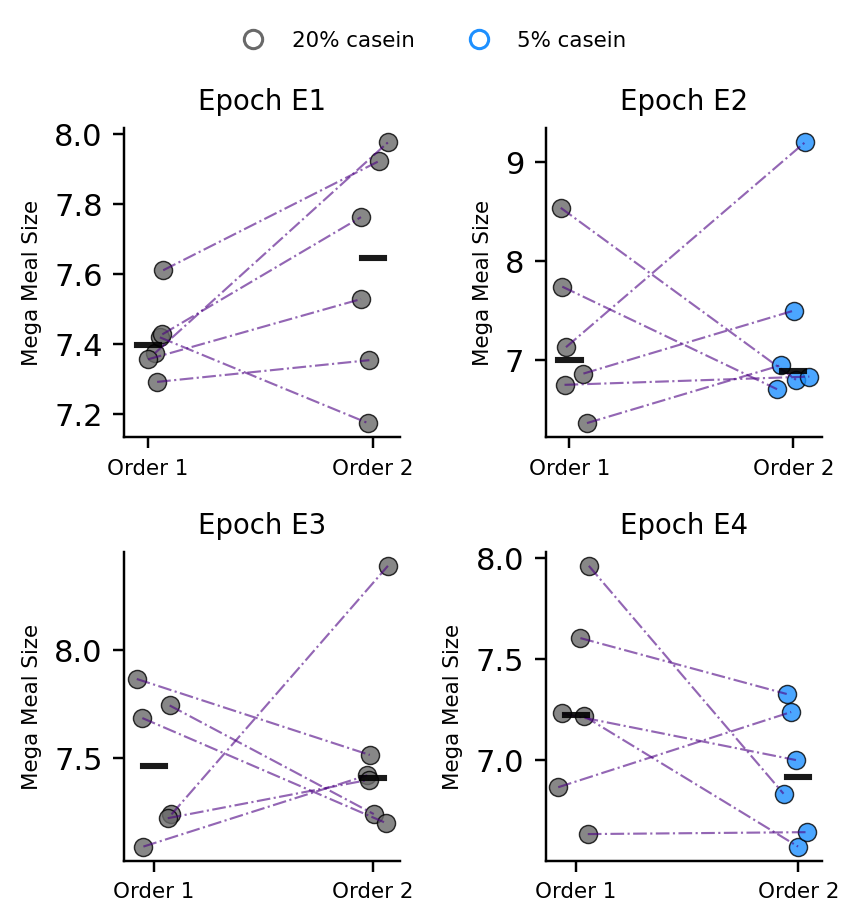

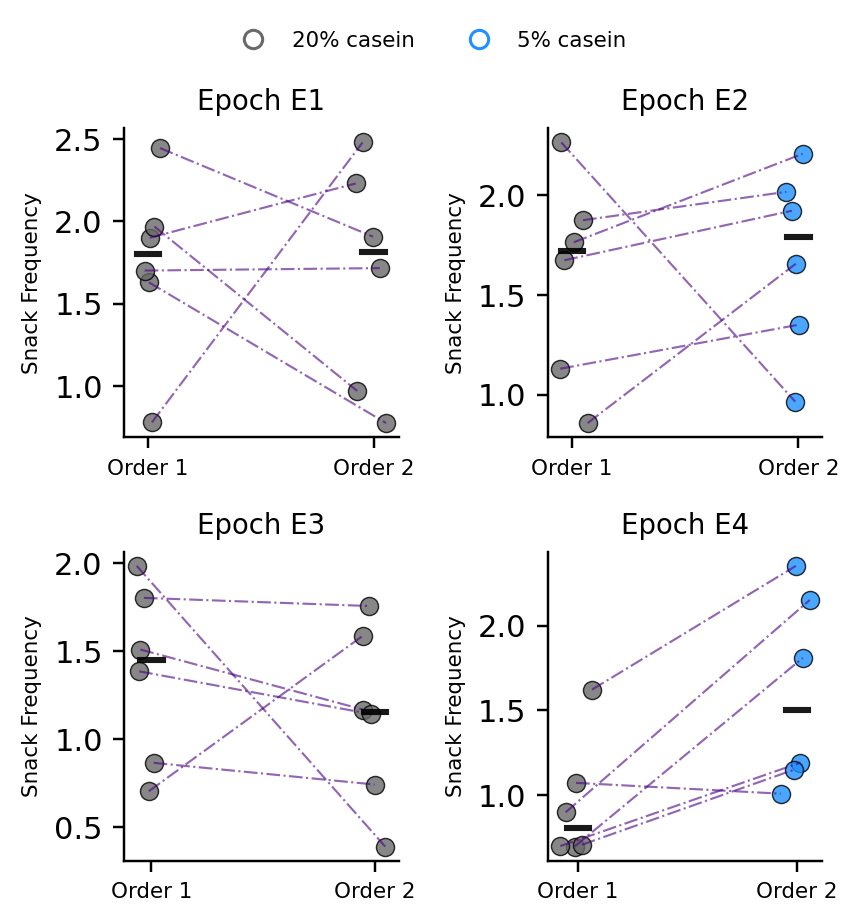

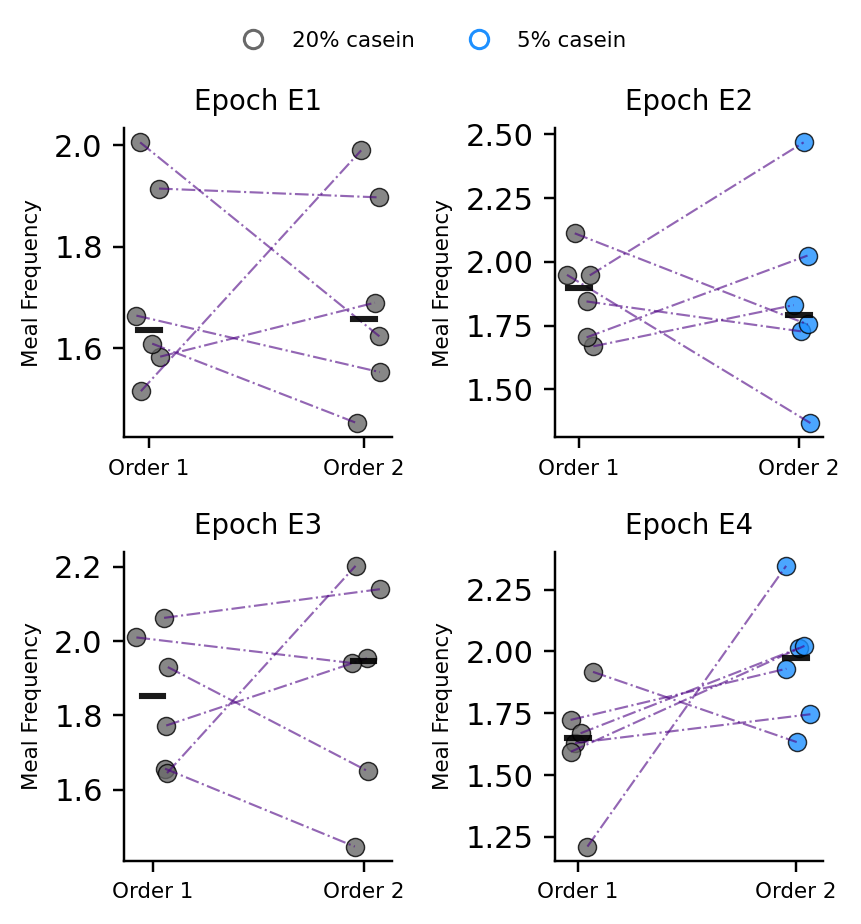

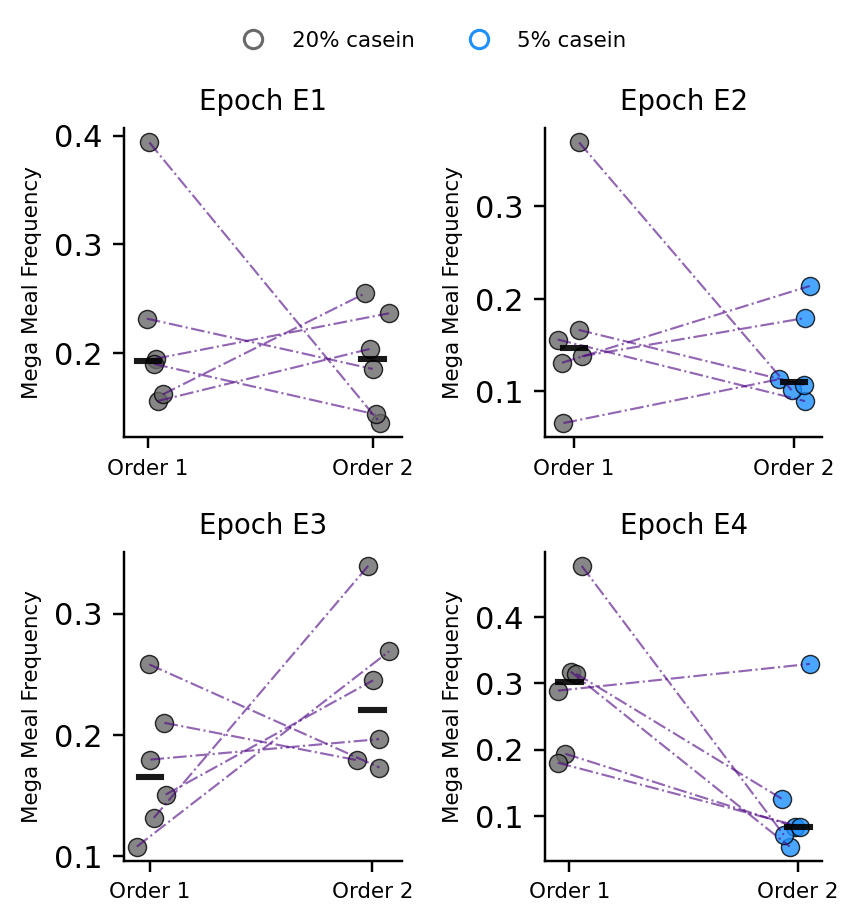

In [47]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results_2.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        elif isinstance(value, (int, float)):
            return [value]  # Convert single values to lists
        else:
            return value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to relevant columns
for epoch in ["E1", "E2", "E3", "E4"]:
    for metric in ["number_of_snacks", "number_of_meals", "number_of_mega_meals", 
                   "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency", "mega_meal_frequency"]:
        column_name = f"epoch_{epoch}_{metric}"
        if column_name in epoch_results_df.columns:
            epoch_results_df[column_name] = epoch_results_df[column_name].apply(convert_to_list)

# Compute total metrics per epoch per order
total_metrics_per_epoch = {metric: {epoch: {"Order 1": [], "Order 2": []} 
                                     for epoch in ["E1", "E2", "E3", "E4"]} 
                           for metric in ["number_of_snacks", "number_of_meals", "number_of_mega_meals", 
                                          "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency", "mega_meal_frequency"]}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        for metric in total_metrics_per_epoch.keys():
            metric_data = row[f"epoch_{epoch}_{metric}"]
            # Ensure metric_data is a list
            if not isinstance(metric_data, list):
                metric_data = [metric_data]
            # For E1, only exclude first two days if there are more than two values (i.e. daily lists)
            if epoch == "E1" and isinstance(metric_data, list) and len(metric_data) > 2:
                metric_data = metric_data[2:]
            total_value = sum(metric_data)
            total_metrics_per_epoch[metric][epoch][order].append(total_value)

# Generate plots for each metric
for metric in total_metrics_per_epoch.keys():
    fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=220)
    epochs = ["E1", "E2", "E3", "E4"]
    jitter_strength = 0.08

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        orders = ["Order 1", "Order 2"]
        order1_data = total_metrics_per_epoch[metric][epoch]["Order 1"]
        order2_data = total_metrics_per_epoch[metric][epoch]["Order 2"]

        # Correct colors based on casein content
        colors = {"E1": {"Order 1": "dimgray", "Order 2": "dimgray"},
                  "E2": {"Order 1": "dimgray", "Order 2": "dodgerblue"},
                  "E3": {"Order 1": "dimgray", "Order 2": "dimgray"},
                  "E4": {"Order 1": "dimgray", "Order 2": "dodgerblue"}}
        
        # Jittered x positions
        order1_x = [0 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order1_data]
        order2_x = [1 + np.random.uniform(-jitter_strength, jitter_strength) for _ in order2_data]

        # Scatter plot with adjusted marker sizes
        sns.scatterplot(x=order1_x, y=order1_data, color=colors[epoch]["Order 1"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
        sns.scatterplot(x=order2_x, y=order2_data, color=colors[epoch]["Order 2"], marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
        
        for j in range(min(len(order1_data), len(order2_data))):
            ax.plot([order1_x[j], order2_x[j]], [order1_data[j], order2_data[j]], color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
        
        # Add median lines for each order
        for order, data, x_pos in zip(["Order 1", "Order 2"], [order1_data, order2_data], [0, 1]):
            median_value = np.median(data)
            ax.plot([x_pos - 0.05, x_pos + 0.05], [median_value, median_value], color='black', linewidth=2, alpha=0.9)
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Order 1", "Order 2"], fontsize=7)
        ax.set_ylabel(metric.replace("_", " ").title(), fontsize=7)
        ax.set_title(f"Epoch {epoch}", fontsize=9)
        sns.despine()

    # Customize legend with markers
    custom_lines = [
        Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6, label='20% casein', fillstyle='none'),
        Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6, label='5% casein', fillstyle='none')
    ]
    fig.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=7, ncol=2)

    plt.tight_layout()
    plt.show()
    
    # Uncomment to save figures
    # fig.savefig(f"..//plots/NEW_MEAL_PLOTS/{metric}_per_epoch.png")


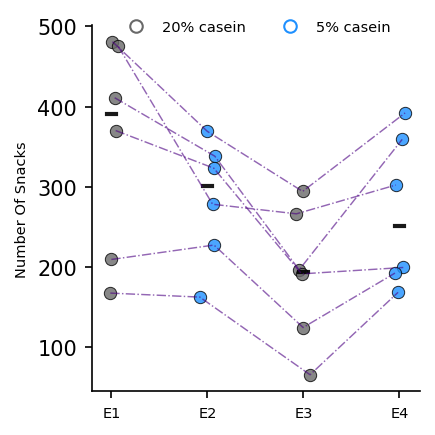

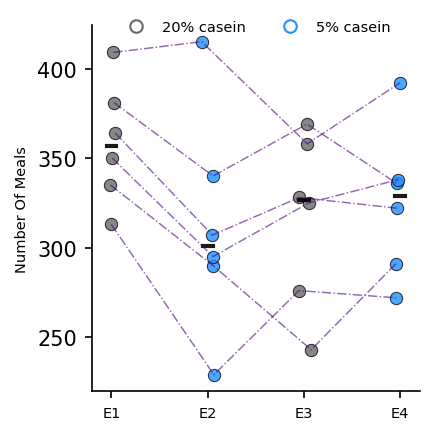

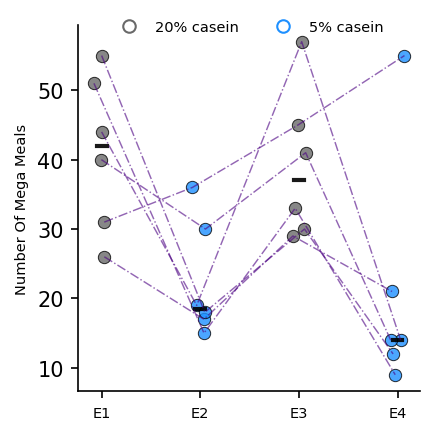

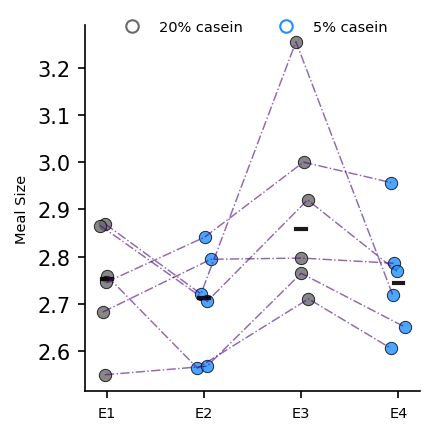

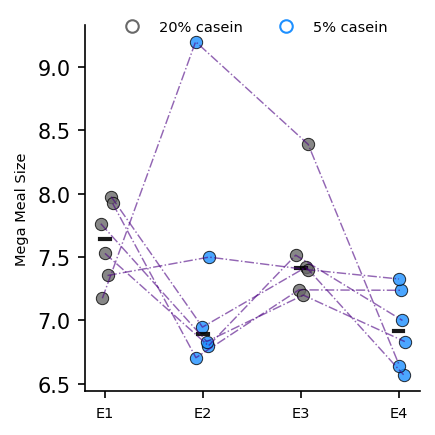

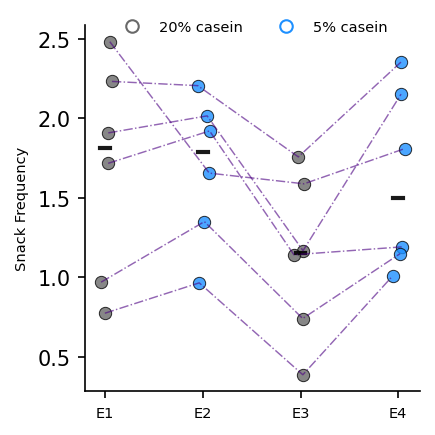

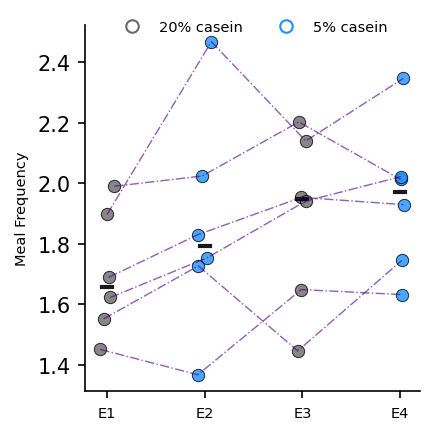

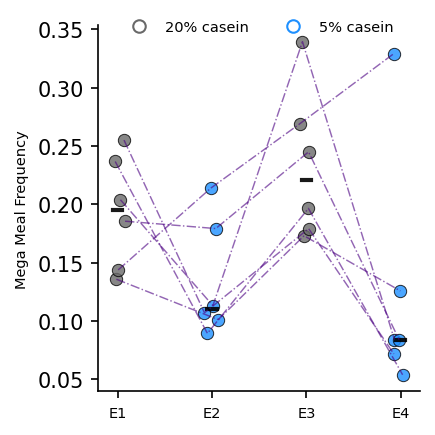

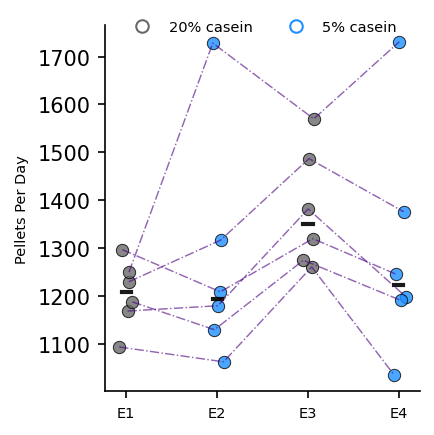

In [55]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from matplotlib.lines import Line2D

# Load the CSV file containing epoch analysis results
epoch_results_path = "epoch_analysis_results_2.csv"
epoch_results_df = pd.read_csv(epoch_results_path)

# Function to convert string lists to numerical lists
def convert_to_list(value):
    try:
        if isinstance(value, str):
            return ast.literal_eval(value)
        elif isinstance(value, (int, float)):
            return [value]  # Convert single values to lists
        else:
            return value
    except (SyntaxError, ValueError):
        return []

# Apply conversion to relevant columns (including pellets_per_day)
for epoch in ["E1", "E2", "E3", "E4"]:
    for metric in ["number_of_snacks", "number_of_meals", "number_of_mega_meals", 
                   "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency", "mega_meal_frequency", 
                   "pellets_per_day"]:
        column_name = f"epoch_{epoch}_{metric}"
        if column_name in epoch_results_df.columns:
            epoch_results_df[column_name] = epoch_results_df[column_name].apply(convert_to_list)

# Define the list of metrics to plot (excluding snack size) and including total pellets taken.
metrics_to_plot = ["number_of_snacks", "number_of_meals", "number_of_mega_meals",
                   "meal_size", "mega_meal_size", "snack_frequency", "meal_frequency", "mega_meal_frequency",
                   "pellets_per_day"]

# Compute total metrics per epoch per order
total_metrics_per_epoch = {metric: {epoch: {"Order 1": [], "Order 2": []}
                                     for epoch in ["E1", "E2", "E3", "E4"]}
                           for metric in metrics_to_plot}

for _, row in epoch_results_df.iterrows():
    order = f"Order {row['order']}"
    for epoch in ["E1", "E2", "E3", "E4"]:
        for metric in metrics_to_plot:
            metric_data = row[f"epoch_{epoch}_{metric}"]
            # Ensure metric_data is a list
            if not isinstance(metric_data, list):
                metric_data = [metric_data]
            # For E1, if there are more than two values, exclude the first two days
            if epoch == "E1" and len(metric_data) > 2:
                metric_data = metric_data[2:]
            total_value = sum(metric_data)
            total_metrics_per_epoch[metric][epoch][order].append(total_value)

# --- Plot only Order 2 data in a single axis per metric ---
# Define epochs and corresponding x positions
epochs = ["E1", "E2", "E3", "E4"]
x_positions = {"E1": 0, "E2": 1, "E3": 2, "E4": 3}
# Colors for each epoch (as before for Order 2)
epoch_colors = {"E1": "dimgray", "E2": "dodgerblue", "E3": "dimgray", "E4": "dodgerblue"}
jitter_strength = 0.08

for metric in metrics_to_plot:
    # Gather Order 2 data for each epoch
    order2_data_by_epoch = {epoch: total_metrics_per_epoch[metric][epoch]["Order 2"] for epoch in epochs}
    # Assume number of Order 2 mice is consistent across epochs
    num_mice = len(order2_data_by_epoch[epochs[0]])
    
    # Dictionary to store jittered x positions for connecting lines
    jittered_x_by_epoch = {}
    
    # Use a smaller figure size here (3x3 inches at 150 dpi)
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    
    # For each epoch, plot Order 2 datapoints with jitter and add a median line
    for epoch in epochs:
        x_pos = x_positions[epoch]
        data = order2_data_by_epoch[epoch]
        jittered_x = [x_pos + np.random.uniform(-jitter_strength, jitter_strength) for _ in data]
        jittered_x_by_epoch[epoch] = jittered_x
        sns.scatterplot(x=jittered_x, y=data, color=epoch_colors[epoch],
                        marker='o', s=35, alpha=0.8, edgecolor="black", ax=ax)
        median_val = np.median(data) if len(data) > 0 else 0
        ax.plot([x_pos - 0.05, x_pos + 0.05], [median_val, median_val],
                color='black', linewidth=2, alpha=0.9)
    
    # Connect each mouse's datapoints across epochs with dashed lines
    for i in range(num_mice):
        x_line = [jittered_x_by_epoch[epoch][i] for epoch in epochs]
        y_line = [order2_data_by_epoch[epoch][i] for epoch in epochs]
        ax.plot(x_line, y_line, color='indigo', linestyle='-.', linewidth=0.7, alpha=0.6)
    
    ax.set_xticks([x_positions[ep] for ep in epochs])
    ax.set_xticklabels(epochs, fontsize=7)
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=7)
    # Remove plot titles (no ax.set_title call)
    
    # Add custom legend (same as your original style)
    custom_lines = [
        Line2D([0], [0], marker='o', color='dimgray', linestyle='', markersize=6,
               label='20% casein', fillstyle='none'),
        Line2D([0], [0], marker='o', color='dodgerblue', linestyle='', markersize=6,
               label='5% casein', fillstyle='none')
    ]
    ax.legend(handles=custom_lines, loc="upper center", bbox_to_anchor=(0.5, 1.05),
              frameon=False, fontsize=7, ncol=2)
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    # To save the figure, uncomment the line below:
    # fig.savefig(f"..//plots/NEW_MEAL_PLOTS/Order2_{metric}_across_epochs.png")
